source: 
- https://www.kaggle.com/immvab/transformers-covid-19-tweets-sentiment-analysis/comments
- https://www.kaggle.com/mehmetlaudatekman/text-classification-svm-explained
- https://www.kaggle.com/jackttai/coronavirus-tweets-nlp-using-logistic-regression
- https://nbviewer.jupyter.org/github/reetu95/DonorsChoose.org---LogisticRegression/blob/master/Logisticregression_donors.ipynb

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import time
import re

pd.options.mode.chained_assignment = None

In [58]:
train=pd.read_csv("Corona_NLP_train.csv",encoding='latin1')
test=pd.read_csv("Corona_NLP_test.csv",encoding='latin1')

In [59]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [60]:
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [61]:
# Check missing data
train.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [62]:
# Check missing data
test.isnull().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

##### Feature Extraction

In [63]:
# concat data
df = pd.concat([train, test])
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


In [64]:
# shuffle the dataset
df_new = df.sample(frac=1)
df_new

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
14644,18443,63395,Doggerland 2020,21-03-2020,@Mandoline_Blue It's just that rationing in a ...,Positive
598,599,45551,"California, USA",12-03-2020,My region has gone into absolute panic mode #C...,Negative
31104,34903,79855,NaN,06-04-2020,@DSGovernment @akaebube @IAOkowa @OfficialPDPN...,Negative
16595,20394,65346,Resistance City,22-03-2020,1) As many of you know I live in a mid-western...,Negative
25069,28868,73820,Kingdom of Saudi Arabia,29-03-2020,To ensure everyoneÂs safety ? and prevent the...,Extremely Positive
...,...,...,...,...,...,...
13365,17164,62116,NaN,21-03-2020,ETIndustryNews: Hindustan Unilever to slash pr...,Negative
5316,9115,54067,NaN,18-03-2020,"No toilet paper I can handle, no pasta, ok...b...",Extremely Negative
20917,24716,69668,Lost in cyberspace,25-03-2020,Largest food bank on Cape Cod faces shortage o...,Negative
12917,16716,61668,North America,21-03-2020,People need to stop stockpiling there is no sh...,Extremely Negative


In [65]:
#take only 5k data, 40k is too big
df = df_new[:5000]
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
14644,18443,63395,Doggerland 2020,21-03-2020,@Mandoline_Blue It's just that rationing in a ...,Positive
598,599,45551,"California, USA",12-03-2020,My region has gone into absolute panic mode #C...,Negative
31104,34903,79855,NaN,06-04-2020,@DSGovernment @akaebube @IAOkowa @OfficialPDPN...,Negative
16595,20394,65346,Resistance City,22-03-2020,1) As many of you know I live in a mid-western...,Negative
25069,28868,73820,Kingdom of Saudi Arabia,29-03-2020,To ensure everyoneÂs safety ? and prevent the...,Extremely Positive
...,...,...,...,...,...,...
974,975,45927,"Earth, Third Planet from the Sun",13-03-2020,@GovernorLittle @WhiteHouse How many Idahoans ...,Negative
7351,11150,56102,Brampton Ontario Canada,19-03-2020,SWEET BABY JESUS &amp; ALL HIS APOSTLES! I swe...,Extremely Positive
40621,44420,89372,DC,13-04-2020,Covid-19 made 'unthinkable' reforms a reality ...,Extremely Negative
8211,12010,56962,NaN,19-03-2020,"Rising yields, collapsing stock prices.\r\r\n\...",Negative


In [66]:
unrelevant_features = ["UserName","ScreenName","Location","TweetAt"]
df.drop(unrelevant_features,inplace=True,axis=1)
df

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,OriginalTweet,Sentiment
14644,@Mandoline_Blue It's just that rationing in a ...,Positive
598,My region has gone into absolute panic mode #C...,Negative
31104,@DSGovernment @akaebube @IAOkowa @OfficialPDPN...,Negative
16595,1) As many of you know I live in a mid-western...,Negative
25069,To ensure everyoneÂs safety ? and prevent the...,Extremely Positive
...,...,...
974,@GovernorLittle @WhiteHouse How many Idahoans ...,Negative
7351,SWEET BABY JESUS &amp; ALL HIS APOSTLES! I swe...,Extremely Positive
40621,Covid-19 made 'unthinkable' reforms a reality ...,Extremely Negative
8211,"Rising yields, collapsing stock prices.\r\r\n\...",Negative


#### EDA ( Exploratory Data Analysis)

In [67]:
# types of classifications
df["Sentiment"].value_counts()

Positive              1364
Negative              1269
Neutral                919
Extremely Positive     745
Extremely Negative     703
Name: Sentiment, dtype: int64

Text(0, 0.5, 'Number of tweets')

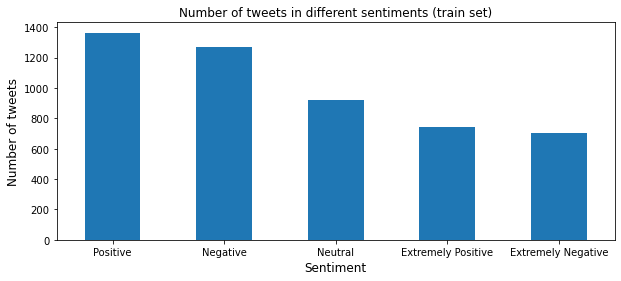

In [68]:
df.Sentiment.value_counts().plot.bar(figsize=(10,4))
plt.xticks(rotation=None)
plt.title('Number of tweets in different sentiments (train set)',fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of tweets', fontsize=12)

In [69]:
# extremely positive -> positvive
# extremely negative -> negative
df['Sentiment'] = df.Sentiment.str.replace('Extremely Positive', 'Positive')
df['Sentiment'] = df.Sentiment.str.replace('Extremely Negative', 'Negative')

<ipython-input-69-9f43367d263e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'] = df.Sentiment.str.replace('Extremely Positive', 'Positive')
<ipython-input-69-9f43367d263e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'] = df.Sentiment.str.replace('Extremely Negative', 'Negative')


Positive    2109
Negative    1972
Neutral      919
Name: Sentiment, dtype: int64


Text(0, 0.5, 'Number of tweets')

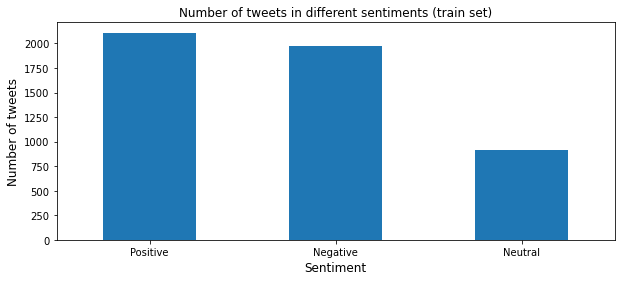

In [70]:
print(df["Sentiment"].value_counts())

df.Sentiment.value_counts().plot.bar(figsize=(10,4))
plt.xticks(rotation=None)
plt.title('Number of tweets in different sentiments (train set)',fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of tweets', fontsize=12)

In [71]:
df.head()

,OriginalTweet,Sentiment
14644,@Mandoline_Blue It's just that rationing in a ...,Positive
598,My region has gone into absolute panic mode #C...,Negative
31104,@DSGovernment @akaebube @IAOkowa @OfficialPDPN...,Negative
16595,1) As many of you know I live in a mid-western...,Negative
25069,To ensure everyoneÂs safety ? and prevent the...,Positive


In [72]:
# Map the sentiment into 0 , 1, 2
df['Sentiment'] = df['Sentiment'].map({'Positive':2, 'Negative':0, 'Neutral':1})

<ipython-input-72-cb0109582e00>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'] = df['Sentiment'].map({'Positive':2, 'Negative':0, 'Neutral':1})


In [73]:
df.head()

,OriginalTweet,Sentiment
14644,@Mandoline_Blue It's just that rationing in a ...,2
598,My region has gone into absolute panic mode #C...,0
31104,@DSGovernment @akaebube @IAOkowa @OfficialPDPN...,0
16595,1) As many of you know I live in a mid-western...,0
25069,To ensure everyoneÂs safety ? and prevent the...,2


##### Negative tweets wordcloud

In [74]:
neg_tweets = df[df.Sentiment == 0]
neg_string = []
for t in neg_tweets.OriginalTweet:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

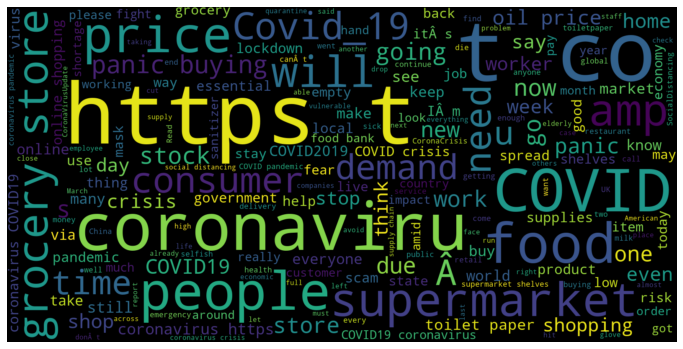

In [75]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

##### Negative tweets wordcloud

In [76]:
pos_tweets = df[df.Sentiment == 2]
pos_string = []
for t in pos_tweets.OriginalTweet:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

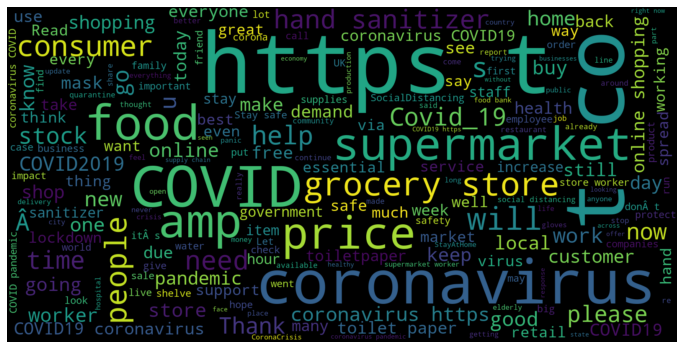

In [77]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

From the wordcloud above, we can observe that there are noises in the tweets, pre-processing is needed

In [78]:
del train
del test

In [79]:
del df_new
del neg_string
del neg_tweets
del pos_string
del pos_tweets

#### Data Pre-Processing

In [80]:
cleanedData = []
def clean_data(text):
    lemma = WordNetLemmatizer()
    swords = stopwords.words("english")
    
    text = re.sub(r'@\w+', '', text) #Remove mentions 
    text=re.sub(r'#\w+', '', text) #Remove hashtags

    # Cleaning links
    text = re.sub(r'http\S+', '', text)

    # Cleaning everything except alphabetical and numerical characters
    text = re.sub("[^a-zA-Z]"," ",text)

    # Tokenizing and lemmatizing
    text = nltk.word_tokenize(text.lower())
    text = [lemma.lemmatize(word) for word in text]

    # Removing stopwords
    text = [word for word in text if word not in swords]

    # Joining the tokens
    text = " ".join(text)

    cleanedData.append(text)
    return text

In [81]:
%%time

df['text']=df['OriginalTweet'].apply(lambda x:clean_data(x))
df

Wall time: 6.43 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,OriginalTweet,Sentiment,text
14644,@Mandoline_Blue It's just that rationing in a ...,2,rationing supermarket say two toilet roll per ...
598,My region has gone into absolute panic mode #C...,0,region ha gone absolute panic mode make sure s...
31104,@DSGovernment @akaebube @IAOkowa @OfficialPDPN...,0,paint rubber garri wa sold yesterday somewhere...
16595,1) As many of you know I live in a mid-western...,0,many know live mid western state rural communi...
25069,To ensure everyoneÂs safety ? and prevent the...,2,ensure everyone safety prevent virus spreading...
...,...,...,...
974,@GovernorLittle @WhiteHouse How many Idahoans ...,0,many idahoan tested date many new test kit see...
7351,SWEET BABY JESUS &amp; ALL HIS APOSTLES! I swe...,2,sweet baby jesus amp apostle swear god going t...
40621,Covid-19 made 'unthinkable' reforms a reality ...,0,covid made unthinkable reform reality u make s...
8211,"Rising yields, collapsing stock prices.\r\r\n\...",0,rising yield collapsing stock price


In [55]:
del df['OriginalTweet']
df

,Sentiment,text
5441,0,asd australian cyber security centre acsc awar...
29947,0,oil price crater saudi russia tension flare op...
9326,1,british public come together beat
19045,1,looking support mum emergency accommodation sh...
15867,0,vodka pernod ricard fort smith tweak process a...
...,...,...
11938,2,usual complain controlled system given free ch...
21525,2,covid 19 pandemic ha many implication consumer...
19965,2,sport direct suggests staff key worker say sto...
9203,0,seen shop charging grossly inflated price esse...


#### Word Embedding
**Note: Data Leakage**<br>
- There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.<br>
- To avoid the issue of data-leakage, make sure to split your data first and then vectorize it.<br>
- While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.<br>

#### Split data
- 90% Test <br>
- 10% Train

In [113]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(df['text'], df['Sentiment'], test_size=.10, random_state=42)

In [118]:
print(x_train.shape)
print(x_test.shape)

(4500,)
(500,)


In [128]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(max_features=10000) #take 10k most common words only
X_train_bow = vect.fit_transform(x_train)
print(vect.get_feature_names())

['aap', 'aapl', 'ab', 'abandon', 'abandoned', 'abandoning', 'abattoir', 'abbott', 'abbreviation', 'abc', 'abeg', 'abide', 'ability', 'able', 'abled', 'abou', 'abrir', 'abroad', 'absence', 'absentee', 'absolute', 'absolutel', 'absolutely', 'absorbed', 'absurd', 'absurdity', 'absynth', 'abt', 'abuja', 'abundance', 'abundant', 'abuse', 'abused', 'abusing', 'abusive', 'ac', 'academic', 'academy', 'acc', 'accc', 'accelerate', 'accelerates', 'accelerating', 'accent', 'accept', 'acceptable', 'accepting', 'access', 'accessed', 'accessibility', 'accessible', 'accessory', 'accident', 'accidentally', 'accidently', 'accommodate', 'accommodation', 'accompanied', 'accomplishment', 'accordance', 'according', 'accordingly', 'account', 'accountability', 'accountable', 'accounted', 'accurate', 'accurately', 'accusation', 'accused', 'accusing', 'accustomed', 'ace', 'achat', 'achieve', 'achieved', 'acid', 'acquire', 'acquiring', 'acre', 'across', 'acrylic', 'acrylonitrile', 'act', 'acted', 'acting', 'acti

In [129]:
x_test_bow = vect.transform(x_test)
print(X_train_bow.shape)
print(y_test_bow.shape) #(row, no. of words)

(4500, 9619)
(500, 2687)


#### Model Selection

In [131]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error

models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    SVC(),
    MultinomialNB(),
    LogisticRegression(max_iter=10000)
]

# 5 fold Cross-validation
kf = KFold(n_splits = 5)

entries = []
for model in models:
    print("Trying Model ", model)
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_bow, y_train, scoring='accuracy', cv=kf).mean()*100
    #for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, accuracies))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'accuracy'])

Trying Model  RandomForestClassifier(max_depth=5, random_state=0)
Trying Model  SVC()
Trying Model  MultinomialNB()
Trying Model  LogisticRegression(max_iter=10000)


In [132]:
cv_df

,model_name,accuracy
0,RandomForestClassifier,52.977778
1,SVC,64.866667
2,MultinomialNB,62.177778
3,LogisticRegression,69.266667


#### LR Model

In [130]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_bow, y_train)
prediction_lr = lr.predict(x_test_bow)

print ("train score: ", lr.score(X_train_bow, y_train))
print ("test score: ", lr.score(x_test_bow, y_test))
print ("Accuracy: ", accuracy_score(y_test, prediction_lr))  #actually same as test score

train score:  0.9935555555555555
test score:  0.718
Accuracy:  0.718


In [135]:
y_pred_lr = cross_val_predict(lr, X_train_bow, y_train, cv = KFold(n_splits=5))
print ("K Fold (5) cross validation accuracy: {:.2f}".format(accuracy_score(y_train,y_pred_lr)))

y_pred_lr = cross_val_predict(lr, X_train_bow, y_train, cv = KFold(n_splits=10))
print ("K Fold (10) cross validation accuracy: {:.2f}".format(accuracy_score(y_train,y_pred_lr)))

K Fold (5) cross validation accuracy: 0.69
K Fold (10) cross validation accuracy: 0.70


In [137]:
md = LogisticRegression(max_iter=10000)
y_train = np.array(y_train)

tr_index=[]
te_index=[]
scores = []
cv = KFold(n_splits=10) # create kfold object
# use .split() method to get a set of train_index and test_index.
# On every iteration we create training and testing data and 
# get its accuracy on that particular data making it a different dataset everytime
for train_index, test_index in cv.split(X_train_bow):
    tr_index.append(train_index)
    te_index.append(test_index)
    x_train_cw, x_test_cw = X_train_bow[train_index], X_train_bow[test_index]
    y_train_cw, y_test_cw = y_train[train_index], y_train[test_index]
    #X_train, X_test, y_train, y_test = x_train.iloc[train_index], x_test.iloc[test_index], y_train.iloc[train_index], y_test.iloc[test_index]
    md.fit(x_train_cw, y_train_cw)
    y_pred_cw = md.predict(x_test_cw)
    scores.append(accuracy_score(y_test_cw, y_pred_cw))

In [139]:
print ("-----------LR with BOW after KFold-----------")

print ("train score: ", md.score(X_train_bow, y_train))
print ("test score: ", md.score(x_test_bow, y_test)) #equivalent to accuracy score

-----------LR with BOW after KFold-----------
train score:  0.9628888888888889
test score:  0.684


althought accuracy score has dropped, but it reduced the overfitting of the model 

But.. it is still overfit. How to overfitting in LR?

source: https://www.kaggle.com/crawford/hyperparameter-search-comparison-grid-vs-random

In [ ]:
# consider use the following lib for hyperparameter tuning

# Grid Search for tuning parameters
from sklearn.model_selection import GridSearchCV
# RandomizedSearch for tuning (possibly faster than GridSearch)
from sklearn.model_selection import RandomizedSearchCV
# Bayessian optimization supposedly faster than GridSearch
from bayes_opt import BayesianOptimization